In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import datetime
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2

In [2]:
"""
# clear logs from previous runs
!rm -rf ./logs/
!mkdir ./logs/

# Download Ngrok to tunnel the tensorboard port to an external port
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

# install new plugin profile
!pip install -U tensorboard-plugin-profile

# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [
    pool.apply_async(os.system, args=(cmd, ), callback = None)
    
    for cmd in [
        f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",
        "./ngrok http 6006 &"
    ]
]

# Get the url to access tensorboard
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
"""

'\n# clear logs from previous runs\n!rm -rf ./logs/\n!mkdir ./logs/\n\n# Download Ngrok to tunnel the tensorboard port to an external port\n!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip\n!unzip -o ngrok-stable-linux-amd64.zip\n\n# install new plugin profile\n!pip install -U tensorboard-plugin-profile\n\n# Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)\npool = multiprocessing.Pool(processes = 10)\nresults_of_processes = [\n    pool.apply_async(os.system, args=(cmd, ), callback = None)\n    \n    for cmd in [\n        f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",\n        "./ngrok http 6006 &"\n    ]\n]\n\n# Get the url to access tensorboard\n! curl -s http://localhost:4040/api/tunnels | python3 -c     "import sys, json; print(json.load(sys.stdin)[\'tunnels\'][0][\'public_url\'])"\n'

In [3]:
# constant values
IMAGE_WIDTH = 254  # 254: the original size, 256: padding
IMAGE_HEIGHT = 254
BATCH_SIZE = 64  # [32, 64, 128], ideal: 64
SEED = 123
VALIDATION_SPLIT = 0.2
NO_OF_EPOCHS = 5
FOLDER = "/kaggle/input/the-flame-dataset"

In [4]:
# import images for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=FOLDER+'/Training/Training',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    batch_size=BATCH_SIZE
)
class_names = train_ds.class_names

# import images for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=FOLDER+'/Training/Training',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    batch_size=BATCH_SIZE,
)

# import images for hold-out test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=FOLDER+'/Test/Test',
    color_mode='rgb',
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.
Found 8617 files belonging to 2 classes.


In [5]:
#train_ds_num = train_ds.as_numpy_iterator()
#print(list(train_ds_num))

In [6]:
"""
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

Categories=['Fire','No_fire']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir=FOLDER+"/Training/Training/"
#path which contains all the categories of images

for i in Categories:
    print(f'loading... category : {i}')    
    path=os.path.join(datadir,i)
    
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
        
    print(f'loaded category:{i} successfully')
    
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data
y=df.iloc[:,-1] #output data
"""

'\nimport pandas as pd\nimport os\nfrom skimage.transform import resize\nfrom skimage.io import imread\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nCategories=[\'Fire\',\'No_fire\']\nflat_data_arr=[] #input array\ntarget_arr=[] #output array\ndatadir=FOLDER+"/Training/Training/"\n#path which contains all the categories of images\n\nfor i in Categories:\n    print(f\'loading... category : {i}\')    \n    path=os.path.join(datadir,i)\n    \n    for img in os.listdir(path):\n        img_array=imread(os.path.join(path,img))\n        img_resized=resize(img_array,(150,150,3))\n        flat_data_arr.append(img_resized.flatten())\n        target_arr.append(Categories.index(i))\n        \n    print(f\'loaded category:{i} successfully\')\n    \nflat_data=np.array(flat_data_arr)\ntarget=np.array(target_arr)\ndf=pd.DataFrame(flat_data) #dataframe\ndf[\'Target\']=target\nx=df.iloc[:,:-1] #input data\ny=df.iloc[:,-1] #output data\n'

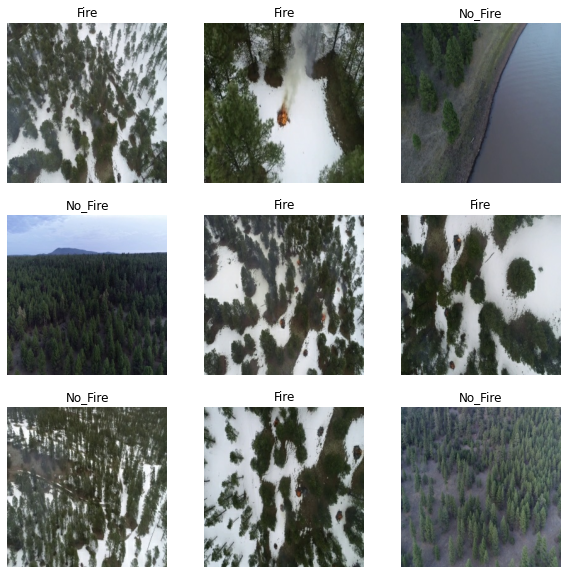

In [7]:
# visualise
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [8]:
# performance optimisation
AUTOTUNE = tf.data.AUTOTUNE
# AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # changed from 32, AUTOTUNE, no cache, no shuffle=1000
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # 32, AUTOTUNE, no cache
# test_ds = test_ds.cache().prefetch

In [9]:
# data augmentation TODO add more data aug?
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ], name="data_aug"
)

In [10]:
# model inputs
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
inputs = keras.Input(shape=input_shape)
# x = inputs
x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
#x = data_augmentation(x)  # comment out if no data_aug

# x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)  # todo: check if it interferes

In [11]:
"""
Adding new model for transfer learning, first get top base
"""
print("Creating model...")  # todo

"""
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=x,
    input_shape=None,
    pooling=None,  # None: original, max: global pooling
    classes=1000,
    classifier_activation="softmax",
)
"""
"""
model = Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=x,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
"""

model = InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=x,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


print("Initial TF model built")  # todo
# print(model.summary())

Creating model...
225214464/225209952 [==============================] - 3s 0us/step
Initial TF model built


In [12]:
"""
Next, get last layer of TF model, and place new layers
"""
# last_layer = model.get_layer('block5_pool').output
last_layer = model.get_layer('avg_pool').output

x = layers.Flatten(name='flatten')(last_layer)
x = layers.Dense(64, activation='relu', name='fc1')(x) # Changed from 64-32, then 32-16
x = layers.Dense(32, activation='relu', name='fc2')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)  # 2 classes

model = keras.Model(inputs, output)

for layer in model.layers[:-3]:
    layer.trainable = False

print("Modified TF model built")

#print(model.summary())

Modified TF model built


In [13]:
# model compilation, building and fitting

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3, epsilon=0.1),  # lr: [def/1e-3, 1], eps: [def/1e-7, 0.1, 1], ideal: [lr: 1e-3, eps:0.1]
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [14]:
# Log directory and tensorboard callback
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
"""
Implement callback which stops early and saves the best model to file
"""
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='xception_model.h5', save_best_only=True),
#    tensorboard_callback
]

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NO_OF_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

# model.save("./output_model")  # todo: doesn't seem necessary cuz of above cell?

Epoch 1/5
493/493 [==============================] - 279s 539ms/step - loss: 0.3702 - accuracy: 0.8208 - val_loss: 0.0789 - val_accuracy: 0.9766
Epoch 2/5
493/493 [==============================] - 145s 292ms/step - loss: 0.0718 - accuracy: 0.9776 - val_loss: 0.0479 - val_accuracy: 0.9851
Epoch 3/5
493/493 [==============================] - 145s 292ms/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.0362 - val_accuracy: 0.9884
Epoch 4/5
493/493 [==============================] - 145s 293ms/step - loss: 0.0386 - accuracy: 0.9858 - val_loss: 0.0289 - val_accuracy: 0.9898
Epoch 5/5
493/493 [==============================] - 145s 293ms/step - loss: 0.0318 - accuracy: 0.9883 - val_loss: 0.0250 - val_accuracy: 0.9916


In [17]:
# model evaluation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NO_OF_EPOCHS)

In [18]:
# test evaluation

test_loss, test_acc = model.evaluate(test_ds, batch_size=BATCH_SIZE)

print("Testing accuracy is: ", test_acc)
print("Testing loss is: ", test_loss)

135/135 [==============================] - 86s 613ms/step - loss: 1.0168 - accuracy: 0.6440
Testing accuracy is:  0.643959641456604
Testing loss is:  1.0168143510818481


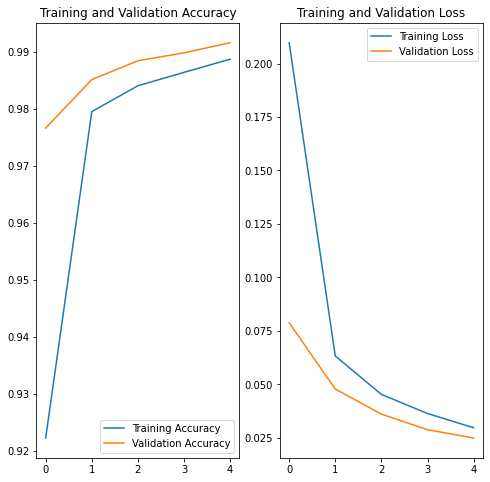

In [19]:
# PLESASE WORK!!!
#epochs_range = range(32)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# fine-tuning

for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[-3:]:
    layer.trainable = False
    
model.compile(loss="binary_crossentropy", 
              optimizer=tf.keras.optimizers.RMSprop(lr=(1e-3/10)), 
              metrics = ["accuracy"])

print(len(model.trainable_variables))
print(model.summary())

488
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 254, 254, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 254, 254, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 254, 254, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 32) 864         tf.math.subtract[0][0]           
__________________________________________________________________________________________

In [ ]:
"""
Implement callback which stops early and saves the best model to file
"""
fine_callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='xception_model_tuned.h5', save_best_only=True),
]

In [31]:
# fit fine-tuned model

fine_tune_epochs = 5
total_epochs =  NO_OF_EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=fine_callbacks)

Epoch 5/10
493/493 [==============================] - 460s 872ms/step - loss: 0.0435 - accuracy: 0.9836 - val_loss: 0.0396 - val_accuracy: 0.9966
Epoch 6/10
493/493 [==============================] - 427s 864ms/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.0056 - val_accuracy: 0.9991
Epoch 7/10
493/493 [==============================] - 427s 864ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 8/10
493/493 [==============================] - 427s 864ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0052 - val_accuracy: 0.9991
Epoch 9/10
493/493 [==============================] - 427s 864ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0090 - val_accuracy: 0.9985
Epoch 10/10
493/493 [==============================] - 427s 864ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0079 - val_accuracy: 0.9990


In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


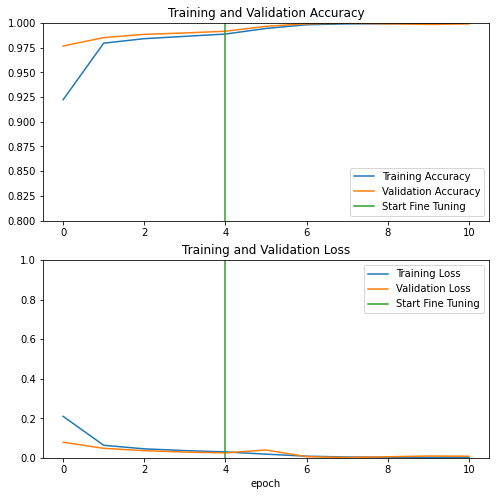

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([NO_OF_EPOCHS-1,NO_OF_EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([NO_OF_EPOCHS-1,NO_OF_EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [35]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)


135/135 [==============================] - 59s 423ms/step - loss: 0.6753 - accuracy: 0.8537
Test accuracy : 0.8536613583564758


In [ ]:
"""
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(8, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x
for size in [8]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

    x = layers.add([x, residual])
    previous_block_activation = x

x = layers.SeparableConv2D(8, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="model_fire")
"""